In [1]:
import sys
sys.path.append('../')
from src.data import SegmentationDataMap
from nuscenes.nuscenes import NuScenes
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
from pyquaternion import Quaternion
import numpy as np
from src.tools import get_local_map
import cv2

In [2]:
import math

def fov_from_intrinsics(K, img_h, img_w):
    fov_x = math.atan2(2*K[0, 0], img_w)
    fov_y = math.atan2(2*K[1, 1], img_h)
    return fov_x, fov_y

### Parameters

In [7]:
version='mini'
dataroot='/home/ruslan/datasets/nuscenes'
gpuid = 0

H=900
W=1600
final_dim=(256, 704)  # (128, 352)
resize_lim = (0.386, 0.450)  # (0.193, 0.225)
bot_pct_lim=(0.0, 0.22)
rot_lim=(-5.4, 5.4)
rand_flip=False
ncams=1

max_grad_norm=5.0
pos_weight=2.13

xbound=[0.0, 32.0, 0.125]
ybound=[-16.0, 16.0, 0.125]
zbound=[-10.0, 10.0, 20.0]
dbound=[4.0, 45.0, 1.0]

# H = 900
# W = 1600
# resize_lim = [0.772, 0.900]
# final_dim = [512, 1408]
# bot_pct_lim = [0.0, 0.22]
# rot_lim = [-5.4, 5.4]
# rand_flip = False
# ncams = 1
# cams = ['CAM_FRONT']

# xbound = [0.0, 69.12, 0.16]
# ybound = [-39.68, 39.68, 0.16]
# zbound = [-10.0, 10.0, 20.0]
# dbound = [4.0, 45.0, 1.0]

bsz=2
nworkers=10
lr=1e-3
weight_decay=1e-7
nepochs = 20

grid_conf = {
    'xbound': xbound,
    'ybound': ybound,
    'zbound': zbound,
    'dbound': dbound,
}

# cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
#         'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
cams = ['CAM_FRONT']

data_aug_conf = {
                'resize_lim': resize_lim,
                'final_dim': final_dim,
                'rot_lim': rot_lim,
                'H': H, 'W': W,
                'rand_flip': rand_flip,
                'bot_pct_lim': bot_pct_lim,
                'cams': cams,
                'Ncams': ncams,
                }


### Load data

In [8]:
from src.tools import get_nusc_maps

nusc = NuScenes(version='v1.0-{}'.format(version),
                dataroot=dataroot,
                verbose=False)

map_folder = dataroot
nusc_maps = get_nusc_maps(map_folder)

valdata = SegmentationDataMap(nusc_maps, nusc, is_train=False, data_aug_conf=data_aug_conf, grid_conf=grid_conf)
traindata = SegmentationDataMap(nusc_maps, nusc, is_train=True, data_aug_conf=data_aug_conf, grid_conf=grid_conf)

NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.386, 0.45), 'final_dim': (256, 704), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT'], 'Ncams': 1}
NuscData: 323 samples. Split: train.
                   Augmentation Conf: {'resize_lim': (0.386, 0.45), 'final_dim': (256, 704), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT'], 'Ncams': 1}


### Explore data

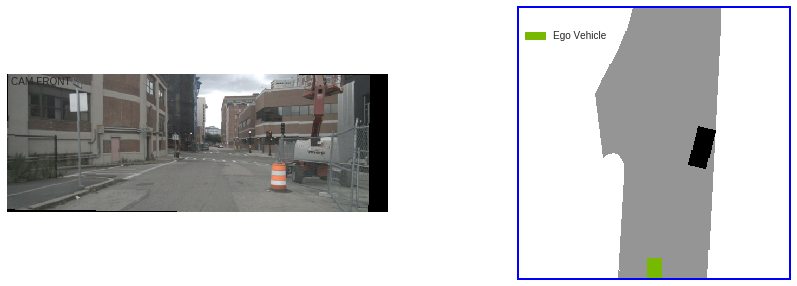

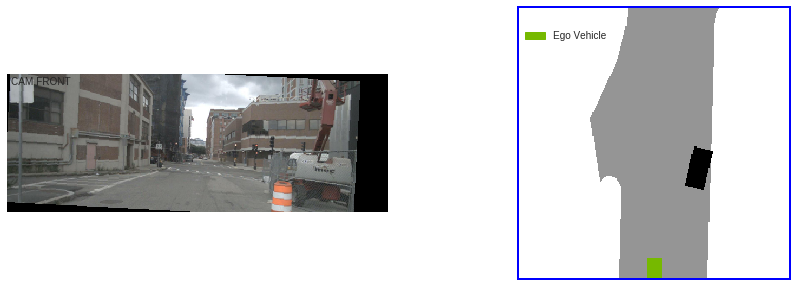

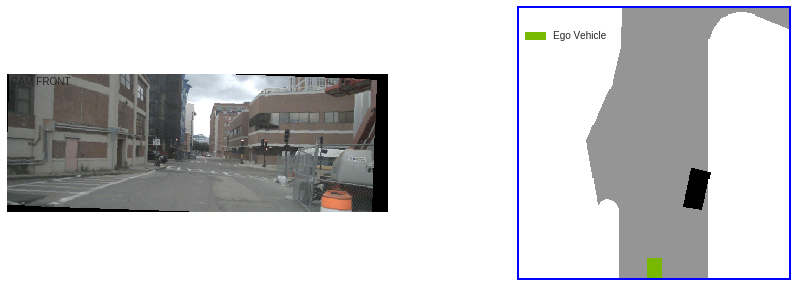

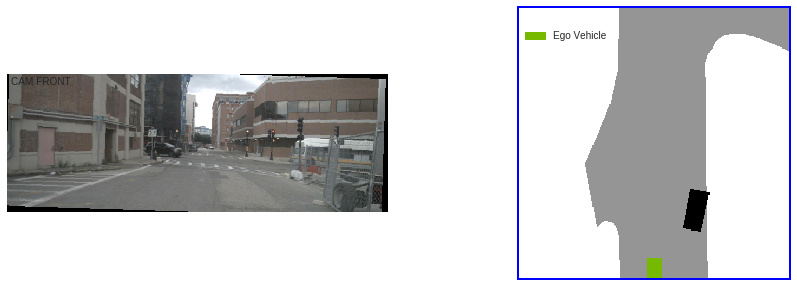

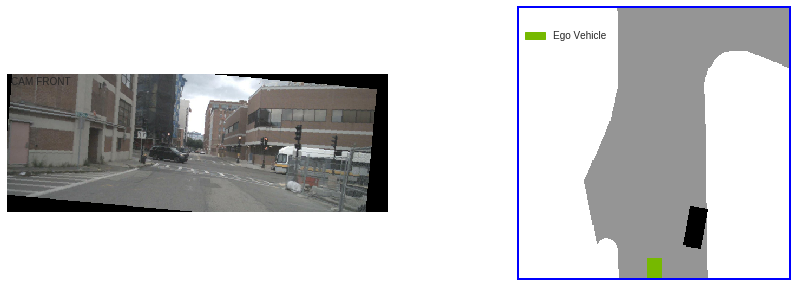

In [9]:
from src.tools import (ego_to_cam, get_only_in_img_mask, denormalize_img,
                    SimpleLoss, get_val_info, add_ego, gen_dx_bx,
                    get_nusc_maps, plot_nusc_map)
from PIL import Image
import matplotlib.patches as mpatches
%matplotlib inline

dx, bx, _ = gen_dx_bx(grid_conf['xbound'], grid_conf['ybound'], grid_conf['zbound'])
dx, bx = dx[:2].numpy(), bx[:2].numpy()

data = traindata

for counter in range(5):  #np.random.choice(range(len(data)), 5):
    imgs, rots, trans, intrins, post_rots, post_trans, map_binimg = data[counter]

    fig = plt.figure(figsize=(15, 5))

    plt.clf()
    for imgi, img in enumerate(imgs):
        ax = plt.subplot(1, 2, 1)
        showimg = denormalize_img(img)
        plt.imshow(showimg)
        plt.axis('off')
        plt.annotate(cams[imgi].replace('_', ' '), (0.01, 0.92), xycoords='axes fraction')

    ax = plt.subplot(1, 2, 2)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.setp(ax.spines.values(), color='b', linewidth=2)
    plt.legend(handles=[
        mpatches.Patch(color='#76b900', label='Ego Vehicle'),
    ], loc=(0.01, 0.86))

    # plot local map
    drivable_area = map_binimg[0, ...]
    cars = map_binimg[1, ...]
    local_map = drivable_area.detach().clone()
    local_map[cars.bool()] = 2.
    plt.imshow(local_map.squeeze(0))
    # camera FOV
#     fov_x, fov_y = fov_from_intrinsics(intrins.squeeze().cpu().numpy(), H, W)
#     R_lookup = data.nx[0]
#     plt.arrow(data.nx[0]/2., 0, R_lookup*np.sin(fov_y/2.), R_lookup*np.cos(fov_y/2.))
#     plt.arrow(data.nx[0]/2., 0, R_lookup*np.sin(-fov_y/2.), R_lookup*np.cos(-fov_y/2.))
    
    plt.xlim((data.nx[0], 0))
    plt.ylim((0, data.nx[1]))
    add_ego(bx, dx)

    plt.show()

In [10]:
imgs.size(), map_binimg.size()

(torch.Size([1, 3, 256, 704]), torch.Size([2, 256, 256]))

### Training

In [7]:
import torch
from time import time
from tensorboardX import SummaryWriter
import numpy as np
import os
from tqdm import tqdm

from src.models import compile_model
from src.tools import SimpleLoss, get_batch_iou, get_val_info

In [8]:
def worker_rnd_init(x):
    np.random.seed(13 + x)
    
trainloader = torch.utils.data.DataLoader(traindata, batch_size=bsz,
                                          shuffle=True,
                                          num_workers=nworkers,
                                          drop_last=True,
                                          worker_init_fn=worker_rnd_init)
valloader = torch.utils.data.DataLoader(valdata, batch_size=1,
                                        shuffle=False,
                                        num_workers=nworkers)

In [10]:
device = torch.device('cpu') if gpuid < 0 else torch.device(f'cuda:{gpuid}')

model = compile_model(grid_conf, data_aug_conf, outC=2)
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_fn = SimpleLoss(pos_weight).cuda(gpuid)

logdir = f'./runs/lss_{time()}'
writer = SummaryWriter(logdir=logdir)

model.train()

counter = 0

for epoch in tqdm(range(nepochs)):
    np.random.seed()
    for batchi, (imgs, rots, trans, intrins, post_rots, post_trans, binimgs) in enumerate(trainloader):
        t0 = time()
        opt.zero_grad()
        preds = model(imgs.to(device),
                rots.to(device),
                trans.to(device),
                intrins.to(device),
                post_rots.to(device),
                post_trans.to(device),
                )
        binimgs = binimgs.to(device)
        loss = loss_fn(preds, binimgs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()
        counter += 1
        t1 = time()
        
        if counter % 10 == 0:
            print(counter, loss.item())
            writer.add_scalar('train/loss', loss, counter)

        if counter % 50 == 0:
            _, _, iou = get_batch_iou(preds, binimgs)
            writer.add_scalar('train/iou', iou, counter)
            writer.add_scalar('train/epoch', epoch, counter)
            writer.add_scalar('train/step_time', t1 - t0, counter)

        if counter % 50 == 0:
            val_info = get_val_info(model, valloader, loss_fn, device)
            print('VAL', val_info)
            writer.add_scalar('val/loss', val_info['loss'], counter)
            writer.add_scalar('val/iou', val_info['iou'], counter)

        if counter % 50 == 0:
            model.eval()
            mname = os.path.join(logdir, "model{}.pt".format(counter))
            print('saving', mname)
            torch.save(model.state_dict(), mname)
            model.train()

### Inference

In [35]:
# load the model
from src.models import compile_model

device = torch.device('cpu') if gpuid < 0 else torch.device(f'cuda:{gpuid}')

# modelf = '../weights/road_cars_12850/model12850.pt'
# modelf = '../weights/road_cars_20400/model20400_iou_static_83_dynamic_34.pt'
# modelf = '../weights/road_cars_25250/model25250.pt'
# modelf = '../weights/road_cars_discr/model_iou_0.8196112240254909.pt'
modelf = '../weights/road_cars_2discr/model_iou_0.8142298854050972.pt'
# modelf = '../weights/road_cars_kitti360/model_iou_0.47.pt' # road+cars segmentation
model = compile_model(grid_conf, data_aug_conf, outC=2)
print('loading', modelf)
model.load_state_dict(torch.load(modelf))
model.to(device);

Loaded pretrained weights for efficientnet-b0
loading ../weights/road_cars_2discr/model_iou_0.8142298854050972.pt


In [12]:
def normalize(tensor):
    tensot_n = tensor - torch.min(tensor)
    return tensot_n / torch.max(tensot_n)    

In [13]:
def pred_to_semseg(out, device, seed=3):
    out = out.sigmoid()

    static = out.squeeze(0)[0, ...].to(device)
    dynamic = out.squeeze(0)[1, ...].to(device)
    
    static = normalize(static)
    dynamic = normalize(dynamic)

    size = cars.size()
    blanks = torch.zeros(size, dtype=torch.float, device=device)

    semseg = torch.cat([static.unsqueeze(2), dynamic.unsqueeze(2), blanks.unsqueeze(2)], dim=2).float()
#     semseg = torch.cat([static.unsqueeze(2), dynamic.unsqueeze(2)], dim=2).float()

    # infer the total number of classes along with the spatial dimensions
    # of the mask image via the shape of the output array
    (height, width, numClasses) = semseg.size()

    # our output class ID map will be num_classes x height x width in
    # size, so we take the argmax to find the class label with the
    # largest probability for each and every (x, y)-coordinate in the
    # image
    classMap = torch.argmax(semseg.float(), axis=-1)

    # given the class ID map, we can map each of the class IDs to its
    # corresponding color
    torch.manual_seed(seed)
    colors = torch.randint(0, 255, size=(numClasses-1, 3), dtype=torch.uint8)
    colors = torch.cat([colors, torch.zeros((1, 3), dtype=torch.uint8)])

    mask = colors[classMap]

    return mask

Single inference took 0.755 sec on input tensor size torch.Size([1, 3, 256, 704])


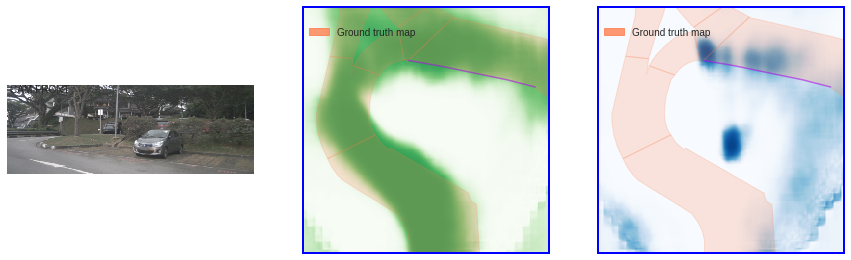

Single inference took 0.027 sec on input tensor size torch.Size([1, 3, 256, 704])


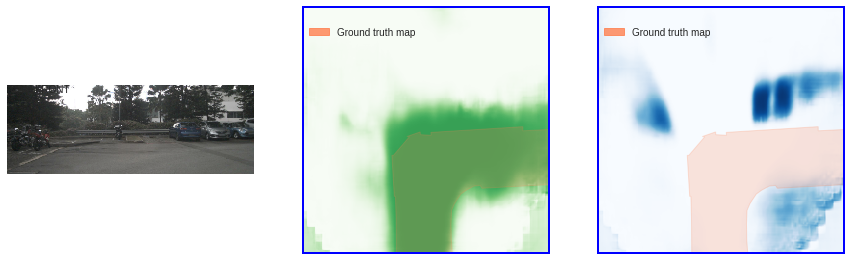

Single inference took 0.028 sec on input tensor size torch.Size([1, 3, 256, 704])


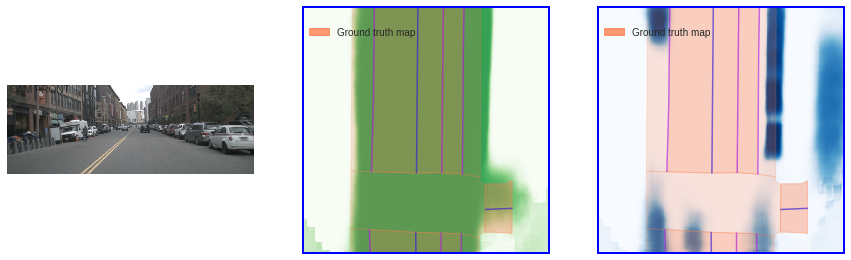

Single inference took 0.025 sec on input tensor size torch.Size([1, 3, 256, 704])


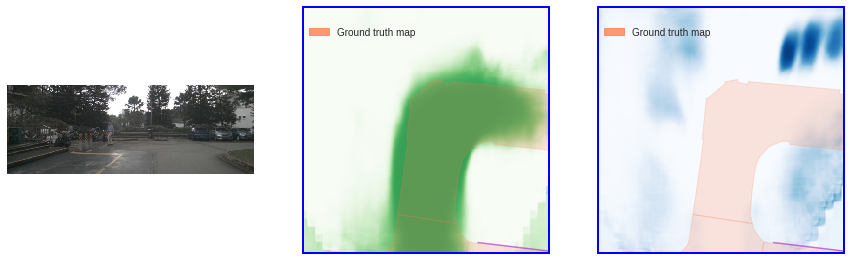

Single inference took 0.025 sec on input tensor size torch.Size([1, 3, 256, 704])


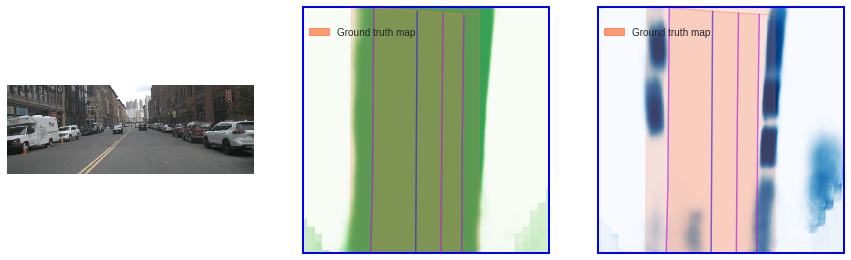

Average FPS: 38.06943343866274 Hz


In [14]:
from time import time

data = valdata

scene2map = {}
for scene in nusc.scene:
    log = nusc.get('log', scene['log_token'])
    scene2map[scene['name']] = log['location']

model.eval()

FPS = []
with torch.no_grad():
    np.random.seed(1)
    for counter in np.random.choice(range(len(data)), 5):
        imgs, rots, trans, intrins, post_rots, post_trans, map_binimg = data[counter]
        
        # inference
        t0 = time()
        out = model(imgs.unsqueeze(0).to(device),
                    rots.unsqueeze(0).to(device),
                    trans.unsqueeze(0).to(device),
                    intrins.unsqueeze(0).to(device),
                    post_rots.unsqueeze(0).to(device),
                    post_trans.unsqueeze(0).to(device),
                    )
        dt = time() - t0
        FPS.append(1./dt)
        print(f'Single inference took {dt:.3f} sec on input tensor size {imgs.size()}')
        
#         local_map = pred_to_semseg(out, device)
        road = out.squeeze(0).sigmoid().cpu()[0, ...]
        cars = out.squeeze(0).sigmoid().cpu()[1, ...]

        fig = plt.figure(figsize=(15, 5))

        plt.clf()
        # RGB image
        ax = plt.subplot(1, 3, 1)
        for imgi, img in enumerate(imgs):
            showimg = denormalize_img(img)
            plt.imshow(showimg)
            plt.axis('off')
            plt.annotate(cams[imgi].replace('_', ' '), (0.01, 0.92), xycoords='axes fraction')

        # Road map
        ax = plt.subplot(1, 3, 2)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.setp(ax.spines.values(), color='b', linewidth=2)
        plt.legend(handles=[
            mpatches.Patch(color=(1.00, 0.50, 0.31, 0.8), label='Ground truth map')
        ], loc=(0.01, 0.86))
        # visualize ground truth road map
        plot_nusc_map(data.ixes[counter], nusc_maps, nusc, scene2map, dx, bx)
        road_show = road #> torch.mean(road)
        plt.imshow(road_show, vmin=0, vmax=1.5, cmap='Greens')
        plt.xlim((data.nx[0], 0))
        plt.ylim((0, data.nx[1]))
        
        # Cars map
        ax = plt.subplot(1, 3, 3)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.setp(ax.spines.values(), color='b', linewidth=2)
        plt.legend(handles=[
            mpatches.Patch(color=(1.00, 0.50, 0.31, 0.8), label='Ground truth map')
        ], loc=(0.01, 0.86))
        # visualize ground truth road map
        plot_nusc_map(data.ixes[counter], nusc_maps, nusc, scene2map, dx, bx)

        cars_show = cars #> 5*torch.mean(cars)
        plt.imshow(cars_show, vmin=0, vmax=1, cmap='Blues')
        plt.xlim((data.nx[0], 0))
        plt.ylim((0, data.nx[1]))

        plt.show()

print(f'Average FPS: {np.mean(FPS[1:])} Hz')

### Occupancy grid

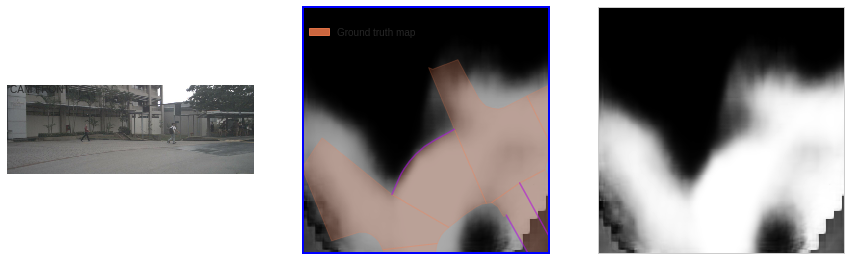

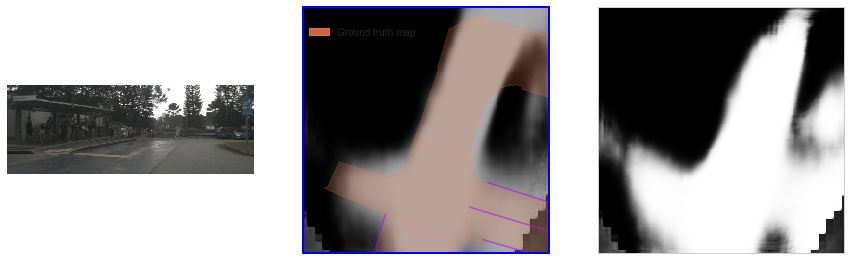

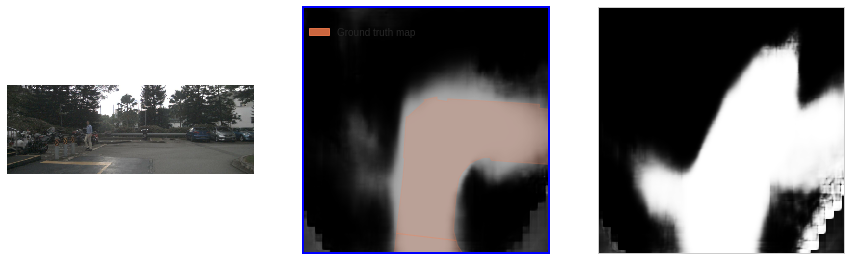

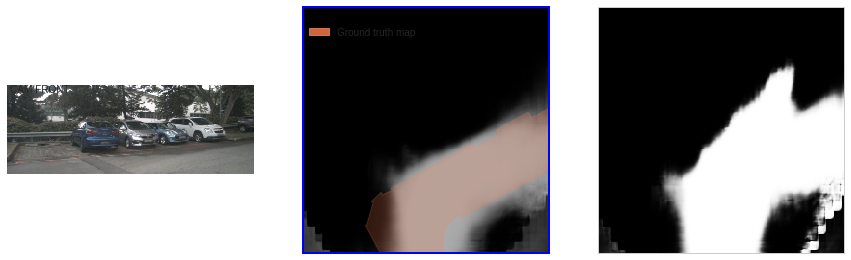

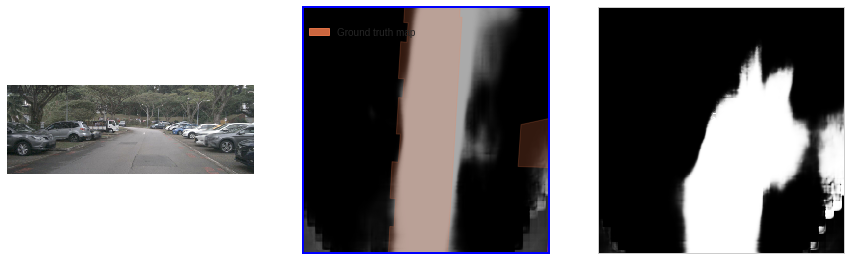

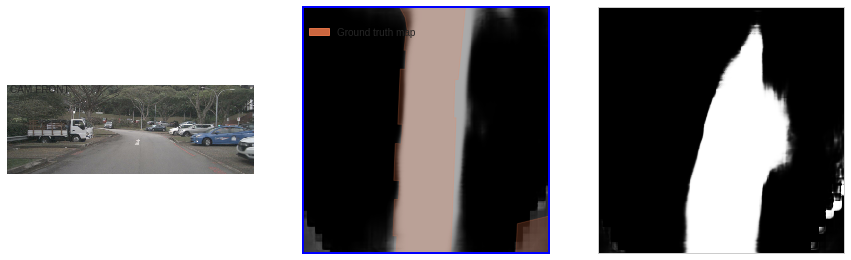

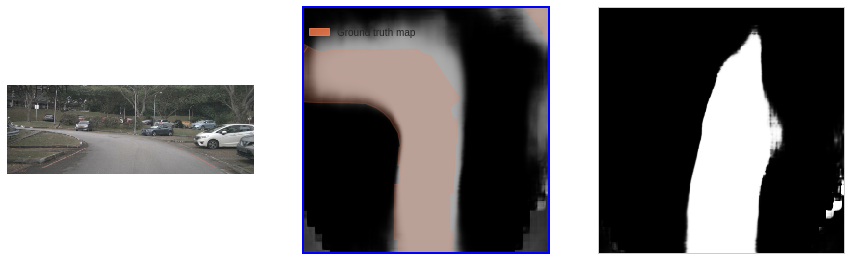

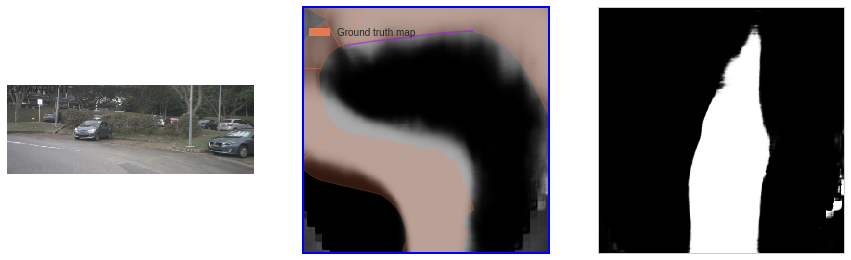

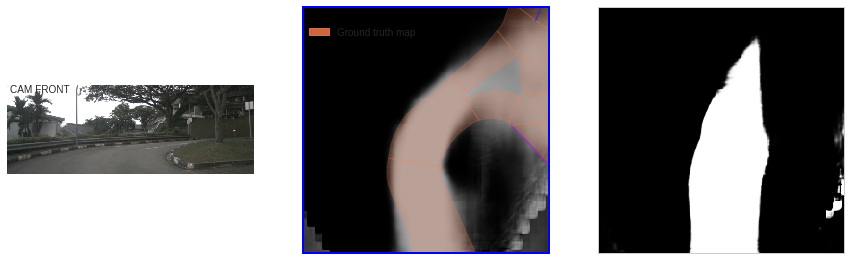

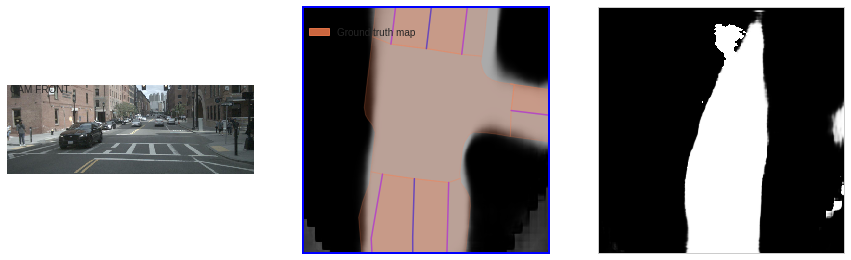

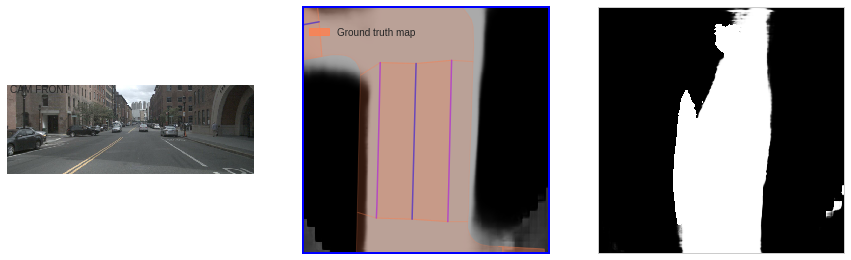

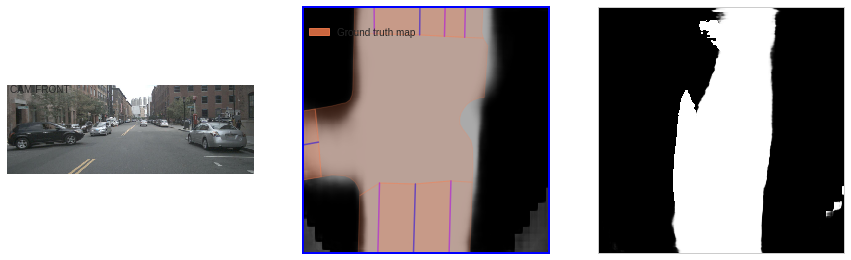

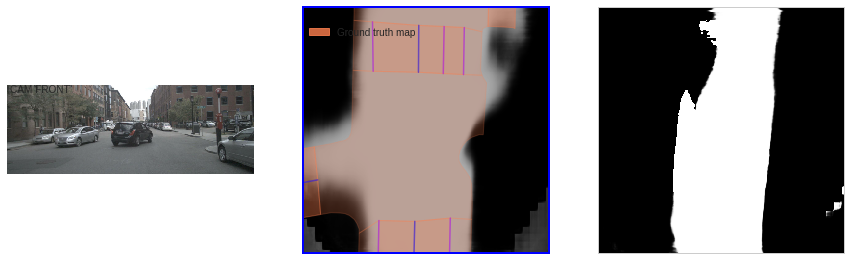

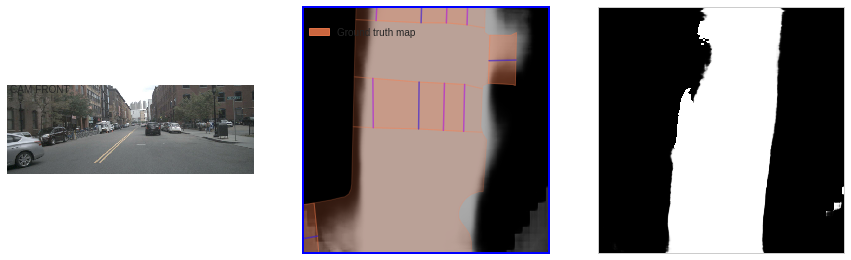

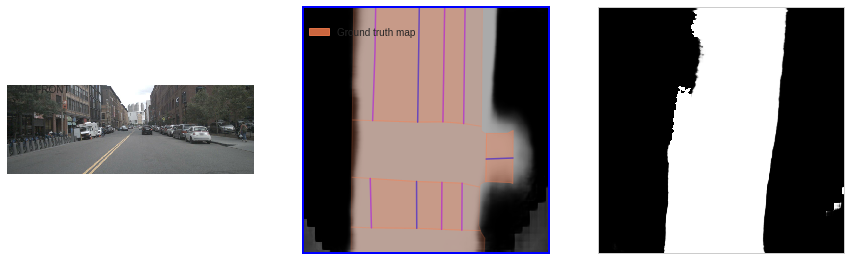

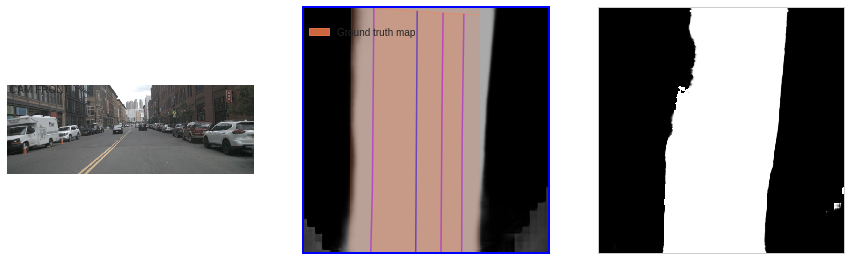

In [30]:
from time import time

data = valdata

scene2map = {}
for scene in nusc.scene:
    log = nusc.get('log', scene['log_token'])
    scene2map[scene['name']] = log['location']

model.eval()

I_sum = 0.
with torch.no_grad():
    for counter in range(80):
        imgs, rots, trans, intrins, post_rots, post_trans, map_binimg = data[counter]
        
        # inference
        out = model(imgs.unsqueeze(0).to(device),
                    rots.unsqueeze(0).to(device),
                    trans.unsqueeze(0).to(device),
                    intrins.unsqueeze(0).to(device),
                    post_rots.unsqueeze(0).to(device),
                    post_trans.unsqueeze(0).to(device),
                    )
        
        road = out.squeeze(0).sigmoid().cpu()[0, ...]
        cars = out.squeeze(0).sigmoid().cpu()[1, ...]

        if counter % 5 == 0:
            fig = plt.figure(figsize=(15, 5))

            plt.clf()
            # RGB image
            ax = plt.subplot(1, 3, 1)
            for imgi, img in enumerate(imgs):
                showimg = denormalize_img(img)
                plt.imshow(showimg)
                plt.axis('off')
                plt.annotate(cams[imgi].replace('_', ' '), (0.01, 0.92), xycoords='axes fraction')

            # Road map
            ax = plt.subplot(1, 3, 2)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.setp(ax.spines.values(), color='b', linewidth=2)
            plt.legend(handles=[
                mpatches.Patch(color=(1.00, 0.50, 0.31, 0.8), label='Ground truth map')
            ], loc=(0.01, 0.86))
            # visualize ground truth road map
            plot_nusc_map(data.ixes[counter], nusc_maps, nusc, scene2map, dx, bx)
            road_show = road
            plt.imshow(road_show, vmin=0, vmax=1.5, cmap='gray')
            plt.xlim((data.nx[0], 0))
            plt.ylim((0, data.nx[1]))

            ax = plt.subplot(1, 3, 3)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.xlim((data.nx[0], 0))
            plt.ylim((0, data.nx[1]))
            I = torch.log(road/(1-road))
            I_sum += I
            grid = 1/(1 + torch.exp(-I_sum))
            plt.imshow(grid, cmap='gray')

            plt.show()
